In [19]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.axes import Axes
from matplotlib.figure import Figure

import utilities_latent as ul
import utilities_plot as up
from utilities_base import VAE, load_data

In [11]:
# 学習済みの重みとデータを読み込む

data, data_id_dict, child_id_dict, word_dict, category_dict = load_data(
    ["data", "data_id_dict", "child_id_dict", "word_dict", "category_dict"]
)
word_count = len(word_dict)

model = VAE().to("cuda")
model.load_state_dict(torch.load("tmp/best_model.pth"))
# model.load_state_dict(torch.load("tmp/model_state_dict.pth"))

<All keys matched successfully>

In [12]:
# カテゴリの表示
for key, val in category_dict.items():
    print(key, len(val))

sounds 12
animals 43
vehicles 14
toys 18
food_drink 68
clothing 28
body_parts 27
household 50
furniture_rooms 33
outside 31
places 22
people 29
games_routines 25
action_words 103
descriptive_words 63
time_words 12
pronouns 25
question_words 7
locations 26
quantifiers 17
helping_verbs 21
connecting_words 6


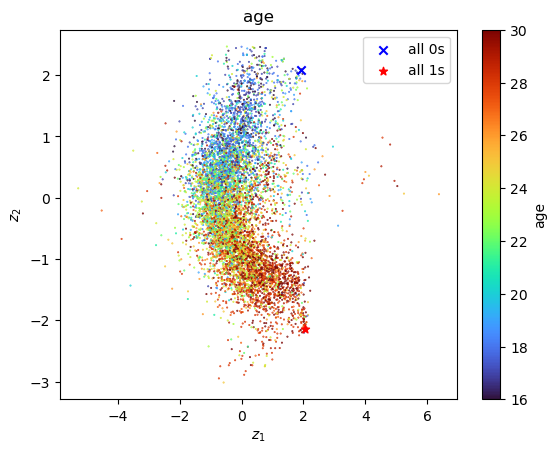

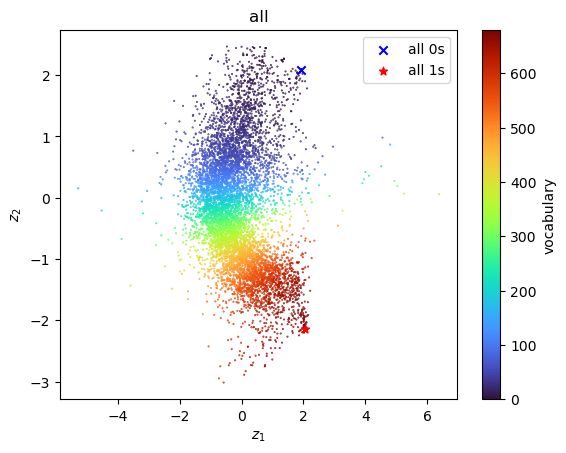

In [13]:
# 年齢の実データと語彙の実データを潜在空間上にプロット

figs = {}
figs["age"] = plt.subplots()
figs["vocabulary"] = plt.subplots()

data_ids = list(data_id_dict.keys())
up.plot_x_with_age(model, data_ids, *figs["age"])
up.plot_x_with_vocabulary(model, data_ids, *figs["vocabulary"], ["all"])
# up.plot_x_with_vocabulary(
#     model,
#     data_ids,
#     *figs["vocabulary"],
#     [上のセルの結果を参考にしてここに語彙のカテゴリを入れる(["all"]だと全語彙)]
# )

In [14]:
# 潜在空間の語彙の発達具合をcategoryごとに可視化

z1_start, z1_end = -6, 7
z2_start, z2_end = -3, 3
spacing = 0.1

z_meshgrid = up.make_lattice_points(z1_start, z1_end, z2_start, z2_end, spacing)
for category in category_dict.keys():
    figs[category] = plt.subplots()
    up.plot_vocabulary(model, z_meshgrid, *figs[category], [category])
    up.plot_x(model, data, figs[category][1], "tab:blue")
    figs[category][0].savefig(f"images/vocabulary/{category}_vocabulary.png")
    plt.close()

In [15]:
# 潜在空間の語彙の発達具合を全categoryまとめて可視化

figs["all"] = plt.subplots()
up.plot_vocabulary(model, z_meshgrid, *figs["all"], ["all"])
up.plot_x(model, data, figs["all"][1], "tab:blue")
figs["all"][0].savefig(f"images/vocabulary/{"all"}_vocabulary.png")
plt.close()

[(2553, 19, 490.0), (2554, 24, 569.0), (2555, 30, 635.0)]


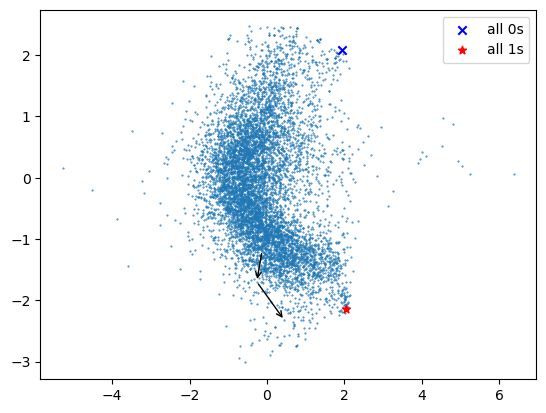

In [16]:
# 縦断データ(同じ子供の年齢が違うデータ)の可視化

figs["arrow"] = plt.subplots()
up.plot_x(model, data, figs["arrow"][1])
data_ids = []

# 何個以上の縦断データを選ぶか
n = 3
for i, v in child_id_dict.items():
    if len(v) >= n:
        data_ids.append([j[0] for j in v])
# print(len(data_ids))

# n個以上の縦断データの中からランダムにm個選んでプロット
m = 1
datas = random.sample(data_ids, m)
child_id = data_id_dict[datas[0][0]][0]
print(child_id_dict[child_id])
for i in datas:
    up.plot_arrow(model, i, figs["arrow"][1])

In [17]:
# 観察しやすそうな実データ

# child_id: 3461, 3499, 2860
tmp_data_id = 3499
tmp_child_id = data_id_dict[tmp_data_id][0]
# print(tmp_child_id)
# print(child_id_dict[tmp_child_id])
data_ids = [i[0] for i in child_id_dict[tmp_child_id]]
print(data_ids)

[3499, 3547, 3652, 3942]


In [20]:
tmp_data = up.child_id_to_data(tmp_child_id)
tmp_z = up.x_to_z(model, tmp_data)
point_O = tmp_z[1, :]
point_A = tmp_z[2, :]
point_P = tmp_z[3, :]

# 直線OPに対してAと対称な点Bを求める
point_B = ul.get_symmetric_points(point_O, point_P, point_A)

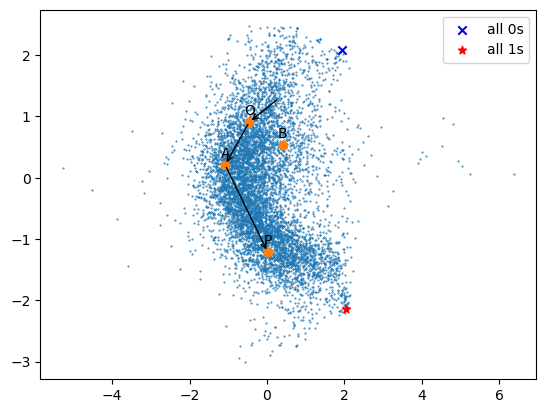

In [21]:
figs["tmp"] = plt.subplots()
fig, ax = figs["tmp"]
up.plot_x(model, data, ax)
up.plot_arrow(model, data_ids, ax)
points = {"O": point_O, "A": point_A, "P": point_P, "B": point_B}
for i in points:
    ax.scatter(points[i][0], points[i][1], color="tab:orange")
    ax.annotate(i, points[i], textcoords="offset points", xytext=(0, 5), ha="center")